In [2]:
## import libraries
import pandas as pd
import numpy as np
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from imblearn.under_sampling import RandomUnderSampler
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.stats.multitest import multipletests
from scipy.stats import pointbiserialr


In [ ]:
# download packages
nltk.download('punkt_tab')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\eilee\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\eilee\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\eilee\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [5]:
from pathlib import Path
import sys

sys.path.append(str(Path().resolve().parent))
from data_preprocessing.preprocessing import preprocessing

df_raw = pd.read_csv('../Data/Raw/Job_Frauds.csv', encoding='latin-1')
df = preprocessing(df_raw)

C:\Users\eilee\OneDrive - National University of Singapore\DSA4263\DSA4263-Project\data_preprocessing\preprocessing.py:27: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df = df.applymap(lambda x: x.lower() if isinstance(x, str) else x)


In [6]:
df = df[df['Country'] == 'us']
df = df.drop(['State','Country'], axis=1)

## Handling Missing Values

In [7]:
# Replace empty string, empty list as NaN
def replace_empty_values(x):
    if isinstance(x, str) and x.strip() == '':
        return np.nan
    elif isinstance(x, list) and len(x) == 0:
        return np.nan
    elif isinstance(x, (list, np.ndarray)) and len(x) == 0:
        return np.nan
    elif x is None:
        return np.nan
    else:
        return x

df = df.map(lambda x: replace_empty_values(x))

print(df.isna().sum())

Job Title                0
Department             120
Range_of_Salary       9099
Profile                  0
Job_Description          0
Requirements             2
Job_Benefits             2
Telecomunication         0
Comnpany_Logo            0
Type_of_Employment       0
Experience               0
Qualification            0
Type_of_Industry         0
Operations             238
Fraudulent               0
City                   586
dtype: int64


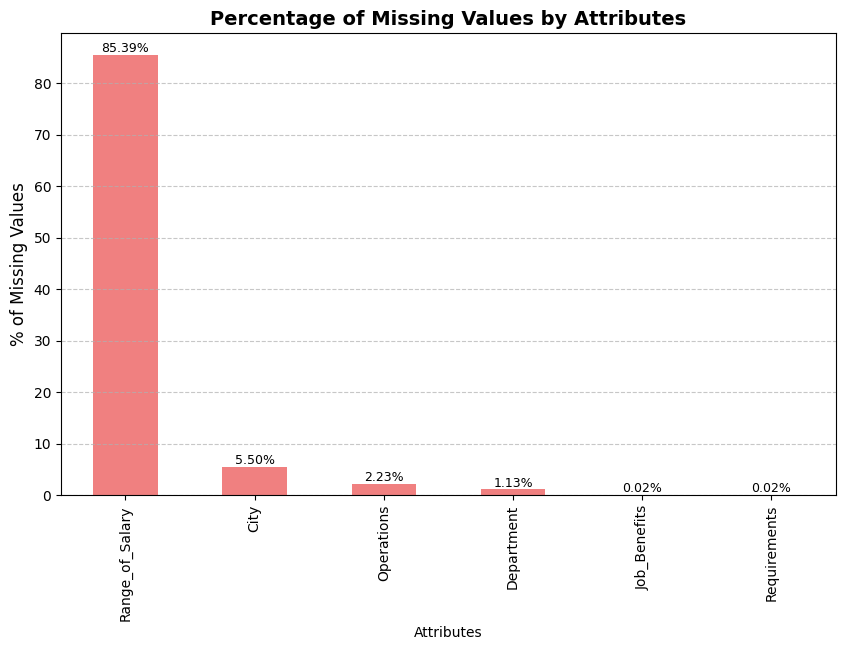

In [10]:
# Distribution of missing values across attributes

missing_percent = (df.isnull().sum() / len(df)) * 100
missing_percent = missing_percent[missing_percent > 0].sort_values(ascending=False)

plt.figure(figsize=(10, 6))
ax = missing_percent.plot(kind='bar', color='lightcoral')

for p in ax.patches:
    ax.annotate(f'{p.get_height():.2f}%', (p.get_x() + p.get_width() / 2, p.get_height()),
                ha='center', va='bottom', fontsize=9, color='black')

plt.title('Percentage of Missing Values by Attributes', fontsize=14, fontweight='bold')
plt.ylabel('% of Missing Values', fontsize=12)
plt.xlabel('Attributes', fontsize=10)
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.show()


In [ ]:
# 'Country' and 'Job_Description' have a very low percentage of missing values, so can be removed safely

# df= df.dropna(subset=['Job_Description','Country'])

# print(df.isnull().sum())

# dropped about 347 out of 17880 rows (1.94% of total rows)

KeyError: ['Country']

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 10656 entries, 0 to 17877
Data columns (total 16 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   Job Title           10656 non-null  object
 1   Department          10536 non-null  object
 2   Range_of_Salary     1557 non-null   object
 3   Profile             10656 non-null  object
 4   Job_Description     10656 non-null  object
 5   Requirements        10654 non-null  object
 6   Job_Benefits        10654 non-null  object
 7   Telecomunication    10656 non-null  int64 
 8   Comnpany_Logo       10656 non-null  int64 
 9   Type_of_Employment  10656 non-null  object
 10  Experience          10656 non-null  object
 11  Qualification       10656 non-null  object
 12  Type_of_Industry    10656 non-null  object
 13  Operations          10418 non-null  object
 14  Fraudulent          10656 non-null  int64 
 15  City                10070 non-null  object
dtypes: int64(3), object(13)
mem

         Attribute  Correlation       P-Value  Adjusted P-Value
0       Department    -0.025421  8.682642e-03      1.302396e-02
1  Range_of_Salary    -0.078182  6.374018e-16      1.912205e-15
2     Requirements    -0.003716  7.013391e-01      7.013391e-01
3     Job_Benefits    -0.003716  7.013391e-01      7.013391e-01
4       Operations     0.036945  1.364189e-04      2.728377e-04
5             City     0.081245  4.479131e-17      2.687478e-16
Missing Value Not significant: ['Requirements', 'Job_Benefits']


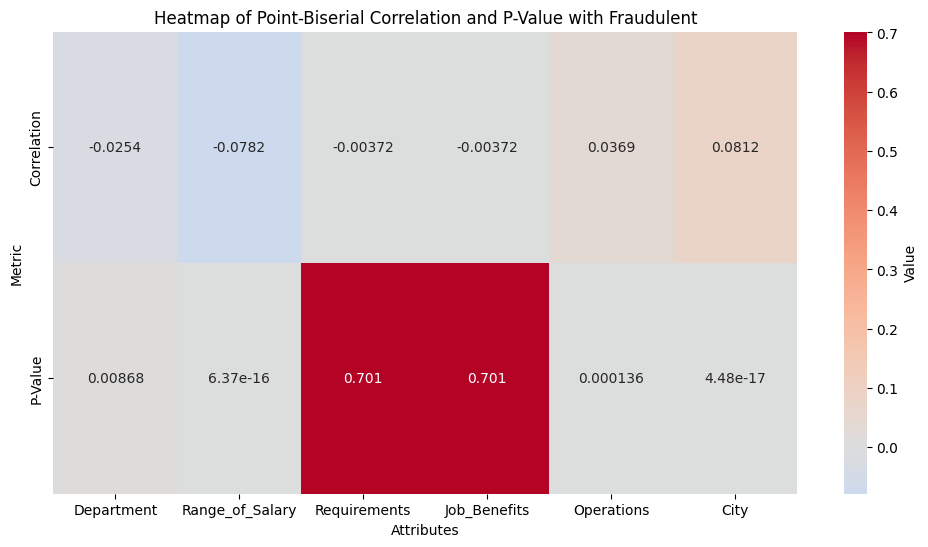

In [12]:
# Compute the correlation and p-value between missing values and 'Fraudulent' occurrences.

# Create Missing Value Indicators (1 if missing, 0 if present)
missing_indicators = df.isna().astype(int)

correlation_results = []

for col in df.columns:
    if col != 'Fraudulent' and missing_indicators[col].sum() > 0:
        # Compute Point-Biserial Correlation and P-Value
        corr, p_value = pointbiserialr(missing_indicators[col], df['Fraudulent'])
        correlation_results.append([col, corr, p_value])

correlation_df = pd.DataFrame(correlation_results, columns=['Attribute', 'Correlation', 'P-Value'])

# Apply False Discovery Rate (FDR) correction for multiple testing
correlation_df['Adjusted P-Value'] = multipletests(correlation_df['P-Value'], method='fdr_bh')[1]
print(correlation_df)

non_significant_columns = correlation_df[correlation_df['Adjusted P-Value'] > 0.05]['Attribute'].tolist()
print("Missing Value Not significant:", non_significant_columns)

# Heatmap Plot
correlation_pvalue_df = correlation_df[['Attribute', 'Correlation', 'P-Value']].set_index('Attribute')
plt.figure(figsize=(12, 6))
sns.heatmap(correlation_pvalue_df.T, annot=True, cmap='coolwarm', center=0, cbar_kws={'label': 'Value'}, fmt='.3g')

plt.xlabel('Attributes')
plt.ylabel('Metric')
plt.title('Heatmap of Point-Biserial Correlation and P-Value with Fraudulent')
plt.show()

In [13]:
# These columns are very significant when unspecified/specified
df['Salary_Specified'] = df['Range_of_Salary'].notna()
df['City_Specified'] = df['City'].notna()

In [14]:
# Replace null values with 'Unspecified' category
df = df.fillna("Unspecified")

In [15]:
#Inpute with median to instead of replacing with 0 to prevent increasing bias
df['Range_of_Salary'] = pd.to_numeric(df['Range_of_Salary'], errors='coerce')
median_salary = df['Range_of_Salary'].median()
df['Range_of_Salary'] = df['Range_of_Salary'].fillna(median_salary).astype(int)


In [ ]:
# Percentage of invalid entries like '8Nov'
# filtered_df = df.loc[df['Range_of_Salary'] != 'Unspecified'].copy()
# # Convert to numeric (invalid values become NaN)
# filtered_df.loc[:, 'Salary_Numeric'] = pd.to_numeric(filtered_df['Range_of_Salary'], errors='coerce')
# percent_invalid = (filtered_df['Salary_Numeric'].isna().sum() /  len(filtered_df)) * 100

# print(f"Percentage of invalid salary entries: {percent_invalid:.2f}%")



Percentage of invalid salary entries: 0.84%


In [116]:
# maybe can remove the invalid entries as the percentage is very low

## EDA

Barplot for Fraudulent Postings by Employment Type

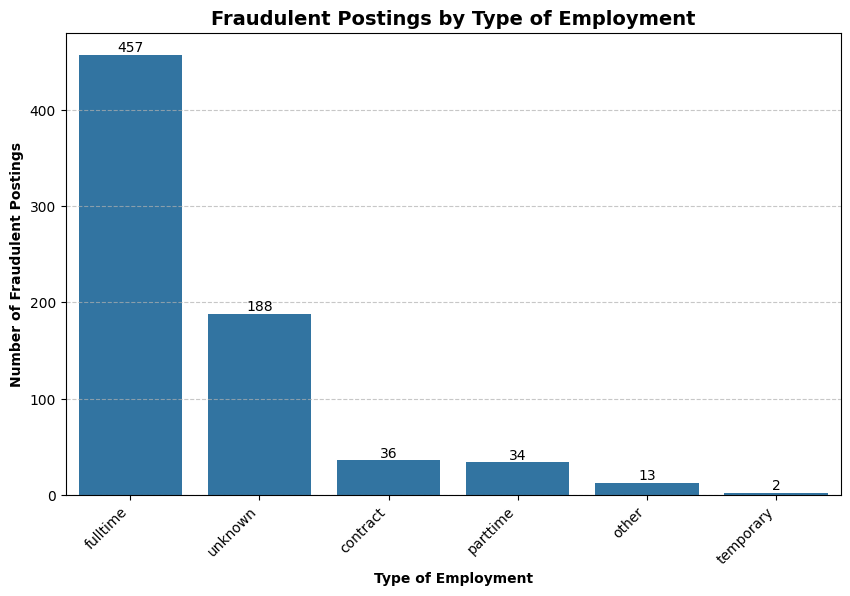

In [16]:
sorted_employment = df.groupby('Type_of_Employment')['Fraudulent'].sum().sort_values(ascending=False).index

plt.figure(figsize=(10, 6))
ax = sns.barplot(data=df, x='Type_of_Employment', y='Fraudulent', estimator=sum, errorbar=None, order=sorted_employment)
plt.title('Fraudulent Postings by Type of Employment', fontsize=14, fontweight='bold')
plt.xlabel('Type of Employment', fontweight='bold')
plt.ylabel('Number of Fraudulent Postings', fontweight='bold')
plt.xticks(rotation=45, ha='right')
ax.grid(axis='y', linestyle='--', alpha=0.7)

for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}', (p.get_x() + p.get_width() / 2, p.get_height()),
                ha='center', va='bottom', fontsize=10, color='black')
plt.show()


Barplot for Fraudulent Postings by Experience

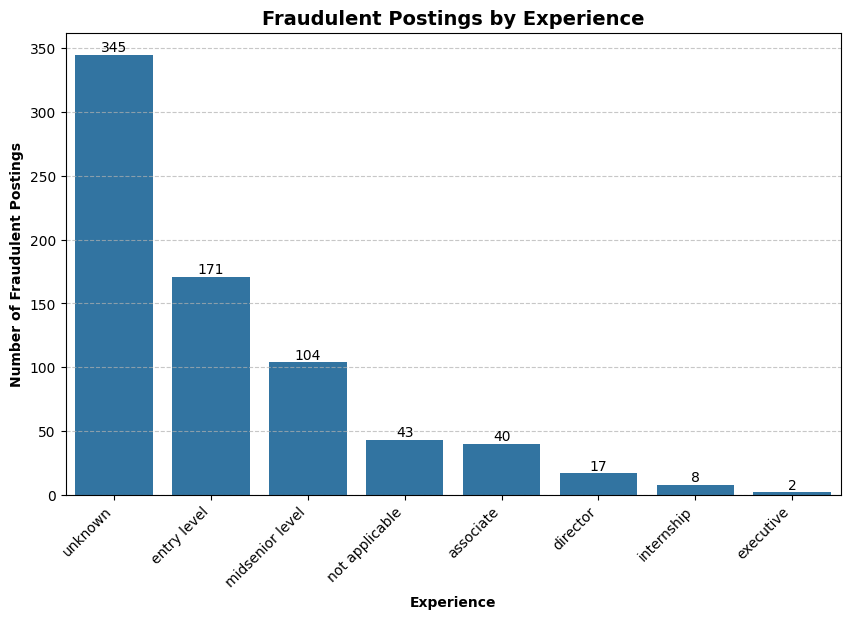

In [17]:
sorted_experience = df.groupby('Experience')['Fraudulent'].sum().sort_values(ascending=False).index
plt.figure(figsize=(10, 6))
ax = sns.barplot(data=df, x='Experience', y='Fraudulent', estimator=sum, errorbar=None, order=sorted_experience)
plt.title('Fraudulent Postings by Experience', fontsize=14, fontweight='bold')
plt.xlabel('Experience', fontweight='bold')
plt.ylabel('Number of Fraudulent Postings', fontweight='bold')
plt.xticks(rotation=45, ha='right')
ax.grid(axis='y', linestyle='--', alpha=0.7)

for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}', (p.get_x() + p.get_width() / 2, p.get_height()),
                ha='center', va='bottom', fontsize=10, color='black')
plt.show()


Barplot for Fraudulent Postings by Qualification

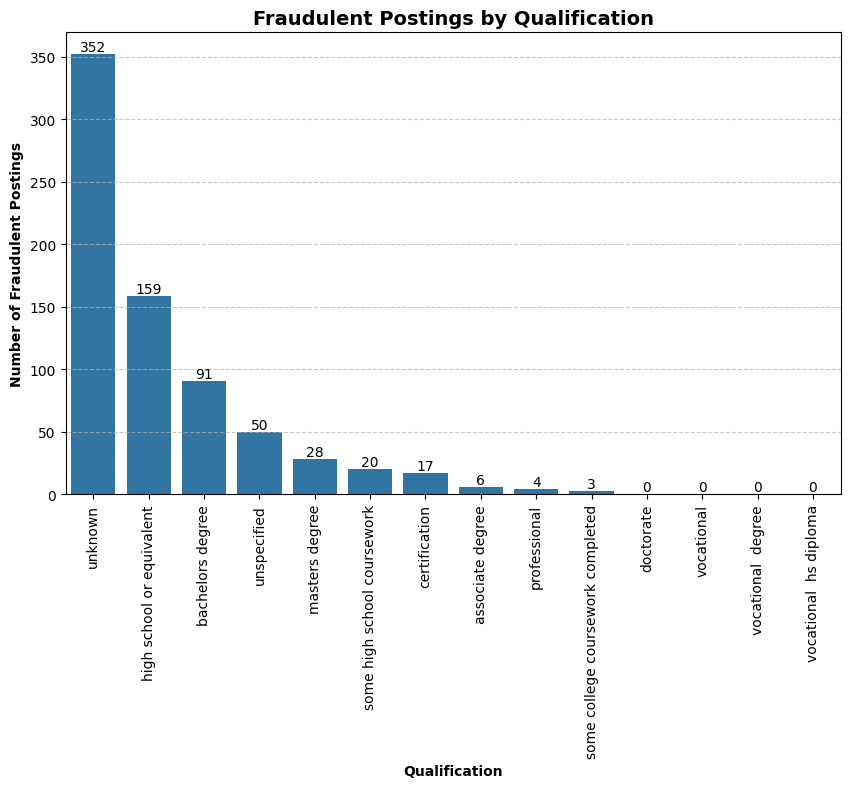

In [18]:

sorted_qualification = df.groupby('Qualification')['Fraudulent'].sum().sort_values(ascending=False).index

plt.figure(figsize=(10, 6))
ax = sns.barplot(data=df, x='Qualification', y='Fraudulent', estimator=sum, errorbar=None, order=sorted_qualification)
plt.title('Fraudulent Postings by Qualification', fontsize=14, fontweight='bold')
plt.xlabel('Qualification', fontweight='bold')
plt.ylabel('Number of Fraudulent Postings', fontweight='bold')
plt.xticks(rotation=90)
ax.grid(axis='y', linestyle='--', alpha=0.7)
for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}', (p.get_x() + p.get_width() / 2, p.get_height()),
                ha='center', va='bottom', fontsize=10, color='black')


plt.show()


In [19]:
df['Qualification'].unique() #why does it show on the graph? last 3?

array(['unknown', 'bachelors degree', 'high school or equivalent',
       'unspecified', 'masters degree',
       'some college coursework completed', 'certification',
       'associate degree', 'doctorate', 'professional',
       'some high school coursework', 'vocational  degree', 'vocational',
       'vocational  hs diploma'], dtype=object)

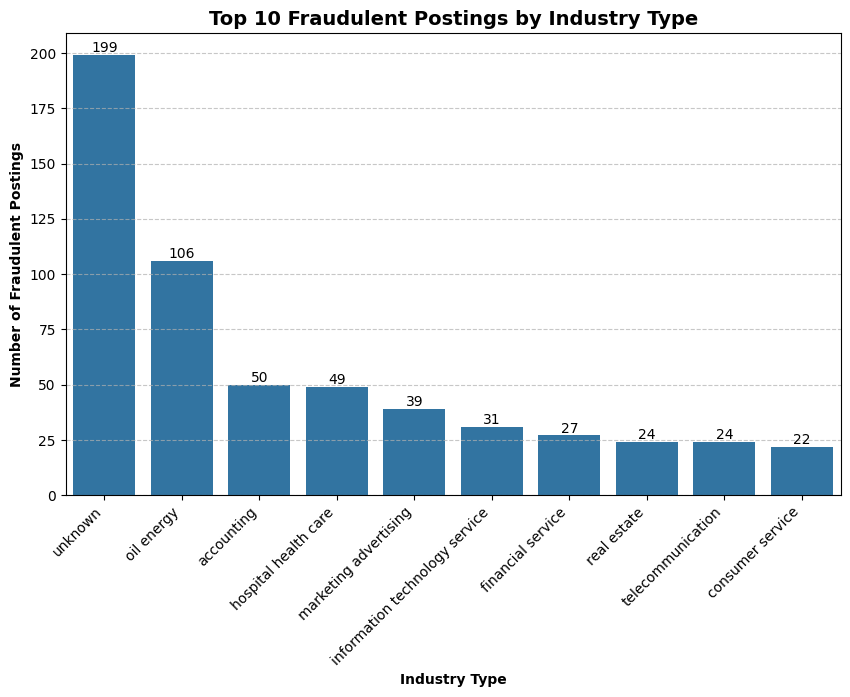

In [20]:
# Top 10 Industries with highest fradulent job posting

top_10_industry = df.groupby('Type_of_Industry')['Fraudulent'].sum().sort_values(ascending=False).head(10)

plt.figure(figsize=(10, 6))
ax = sns.barplot(x=top_10_industry.index, y=top_10_industry.values, estimator=sum, errorbar=None)
plt.title('Top 10 Fraudulent Postings by Industry Type', fontsize=14, fontweight='bold')
plt.xlabel('Industry Type', fontweight='bold')
plt.ylabel('Number of Fraudulent Postings', fontweight='bold')
plt.xticks(rotation=45, ha='right')
ax.grid(axis='y', linestyle='--', alpha=0.7)

for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}', (p.get_x() + p.get_width() / 2, p.get_height()),
                ha='center', va='bottom', fontsize=10, color='black')

plt.show()


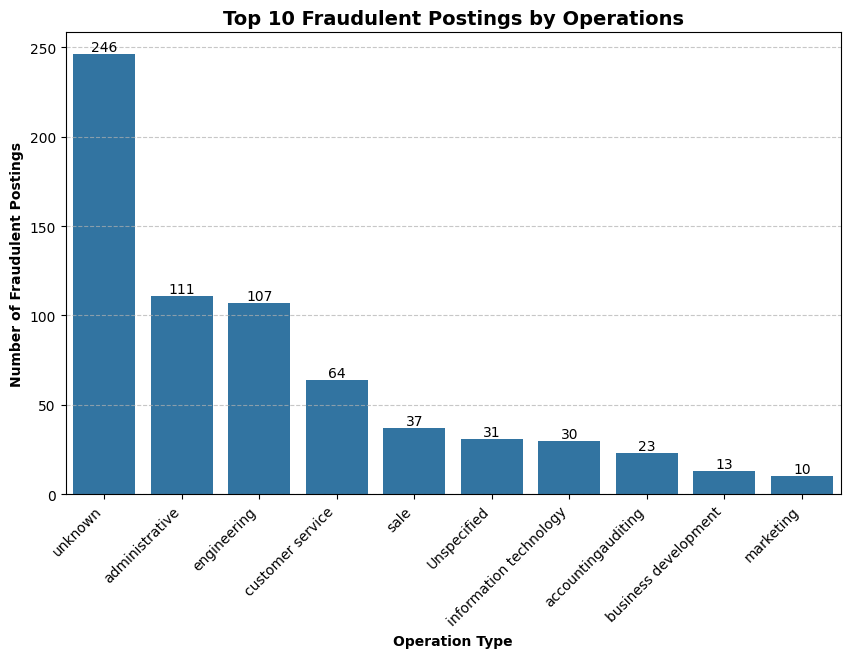

In [21]:
# Top 10 operations with highest fradulent job posting

top_10_operation = df.groupby('Operations')['Fraudulent'].sum().sort_values(ascending=False).head(10)

plt.figure(figsize=(10, 6))
ax = sns.barplot(x=top_10_operation.index, y=top_10_operation.values, estimator=sum, errorbar=None)
plt.title('Top 10 Fraudulent Postings by Operations', fontsize=14, fontweight='bold')
plt.xlabel('Operation Type', fontweight='bold')
plt.ylabel('Number of Fraudulent Postings', fontweight='bold')
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for readability
ax.grid(axis='y', linestyle='--', alpha=0.7)

for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}', (p.get_x() + p.get_width() / 2, p.get_height()),
                ha='center', va='bottom', fontsize=10, color='black')

plt.show()


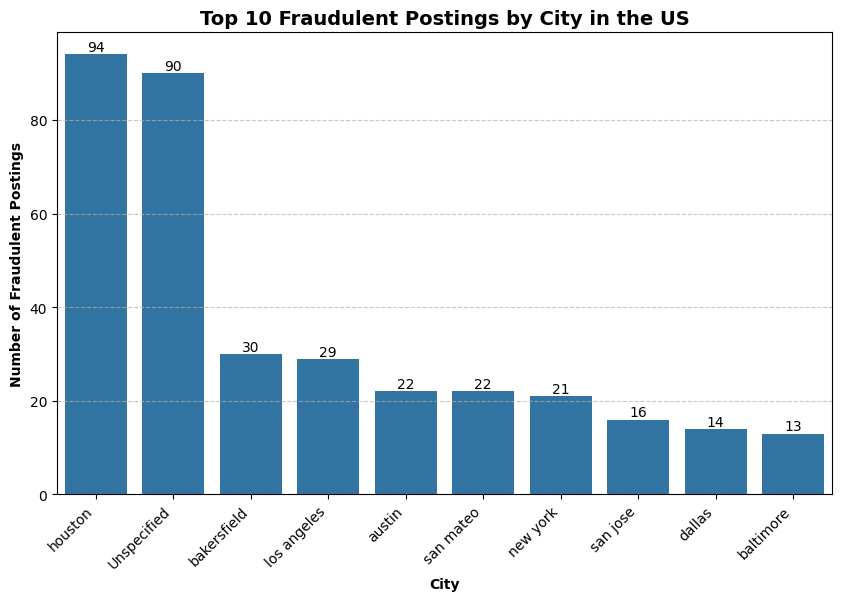

In [24]:
# top 10 city in US with the highest fradulent job posting
top_10_city_fraud = df.groupby('City')['Fraudulent'].sum().sort_values(ascending=False).head(10)

plt.figure(figsize=(10, 6))
ax = sns.barplot(x=top_10_city_fraud.index, y=top_10_city_fraud.values, estimator=sum, errorbar=None)
plt.title('Top 10 Fraudulent Postings by City in the US', fontsize=14, fontweight='bold')
plt.xlabel('City', fontweight='bold')
plt.ylabel('Number of Fraudulent Postings', fontweight='bold')
plt.xticks(rotation=45, ha='right')
ax.grid(axis='y', linestyle='--', alpha=0.7)

for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}', (p.get_x() + p.get_width() / 2, p.get_height()),
                ha='center', va='bottom', fontsize=10, color='black')

plt.show()
